# Question 5

Jack Hart

## Neural Network Code

The following code is from the starter_code doc that builds the network.

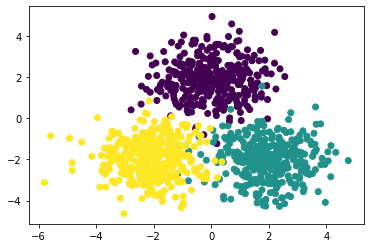

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as py
import time
from plotnine import *

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Generate some training    #
#      data from a GMM        #
###############################
def gen_gmm_data(n = 999, plot=False):
    # Fixing seed for repeatability
    np.random.seed(123)
    
    # Parameters of a normal distribuion
    mean_1 = [0, 2] ; mean_2 = [2, -2] ; mean_3 = [-2, -2]
    mean = [mean_1, mean_2, mean_3] ; cov = [[1, 0], [0, 1]]  
    
    # Setting up the class probabilities
    n_samples = n
    pr_class_1 = pr_class_2 = pr_class_3 = 1/3.0
    n_class = (n_samples * np.array([pr_class_1,pr_class_2, pr_class_3])).astype(int)
  
    # Generate sample data
    for i in range(3):
        x1,x2 = np.random.multivariate_normal(mean[i], cov, n_class[i]).T
        if (i==0):
            xs = np.array([x1,x2])
            cl = np.array([n_class[i]*[i]])
        else: 
            xs_new = np.array([x1,x2])
            cl_new = np.array([n_class[i]*[i]])
            xs = np.concatenate((xs, xs_new), axis = 1)
            cl = np.concatenate((cl, cl_new), axis = 1)
    
    # Plot?
    if plot:
        py.scatter(xs[:1,:],xs[1:,:], c = cl)

    # One hot encoding classes
    y = pd.Series(cl[0].tolist())
    y = pd.get_dummies(y).values

    # Normalizing data (prevents overflow errors)     
    mu = xs.mean(axis = 1)
    std = xs.std(axis = 1)
    xs = (xs.T - mu) / std
    
    return xs, y, cl
             
xs,y,cl = gen_gmm_data(plot = True)

In [34]:
#%%%%%%%%%%%%%%%%%%%%%%%
#    Hidden Units     #
#######################
ReLU = np.vectorize(lambda z: np.fmax(0,z))
sigmoid = lambda z: 1 / (1 + np.exp(-z))
softmax = lambda z: np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

# %%%%%%%%%%%%%%%%%%%%%
#  Utility Functions  #
# #####################
def predict(Y_hat):
    return np.argmax(Y_hat, axis=1)


def error_rate(Y_hat, cl):
    prediction = predict(Y_hat)
    return np.mean(prediction != cl)


def cost(Y_hat, Y):
    tot = Y * np.log(Y_hat)
    return -tot.sum()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   1- Hidden Layer ReLU Network   #
####################################
def forward(X,parameters, drop_out = 1):
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    
    # Forward pass
    a1 = X.dot(W) + b1
    H = ReLU(a1) * drop_out
    # H = sigmoid(a1) * drop_out
    a2 = H.dot(V) + b2
    Y_hat = softmax(a2)
    return H,Y_hat

#%%%%%%%%%%%%%%%
#   Gradient   #
################

def grad(X,H,Y,Y_hat,parameters):  
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    # Gradients - ReLU
    dV = H.T.dot(Y_hat - Y)
    db2 = (Y_hat - Y).sum(axis=0)
    dW = X.T.dot(((Y_hat - Y).dot(V.T) * (H > 0))) 
    db1 = ((Y_hat - Y).dot(V.T) * (H > 0)).sum(axis=0)
    
    # Gradients - sigmoid
    # dW = X.T.dot((Y_hat-Y).dot(V) * (H * (1 - H)))
    # db1 = (Y_hat-Y).dot(V) * (H * (1 - H)).sum(axis=0)
    
    
    #return {'dV':dV,'db2':db2,'dW':dW,'db1':db1}
    return dW,db1,dV,db2

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Parameter Update: Momentum + Regularization   #
###################################################
def parameter_update(parameters,  grads, 
                     momentum_params = [0,0,0,0], 
                     lr = 1, reg = 0, alpha = 0):
    # Unpacking parameters            
    W,b1,V,b2 = parameters
    dW,db1,dV,db2 = grads
    vW,vb1,vV,vb2 = momentum_params
    
    # Momentum update
    vW  = alpha * vW -  lr * (dW + reg*W)
    vb1 = alpha * vb1 - lr * (db1 + reg*b1)
    vV  = alpha * vV -  lr * (dV + reg*V)
    vb2 = alpha * vb2 - lr * (db2 + reg*b2)
    momentum_params = [vW,vb1,vV,vb2] 
    
    # Parameter updates
    W  = W  + vW
    b1 = b1 + vb1
    V  = V  + vV
    b2 = b2 + vb2
    parameters =[W,b1,V,b2]

             
    return parameters, momentum_params

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#  Generate data for network    #
#################################
X, Y, cl = gen_gmm_data()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#      Building the model     #
###############################
def run_model(X, Y, cl,
              nodes_in_hidden_layer = 3,
              num_dim = 2,     # <- number of dimensions here it is 2: x1,x2
              num_classes = 3, # <- number of classes in the problem
              iterations = 100,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False):    

    
    ###################################
    #   Initial values for network    #
    ###################################
    # Intialize weights
    np.random.seed(123)
    W = np.random.randn(num_dim * nodes_in_hidden_layer).reshape(num_dim,nodes_in_hidden_layer)
    b1 = 0
    V = np.random.randn(num_classes * nodes_in_hidden_layer).reshape(nodes_in_hidden_layer,num_classes)
    b2 = 0
    parameters = [W,b1,V,b2]
    
    
    # Hyperparameters 
    lr = 0.0001 # learning rate
    reg = 0.01 * regularization_include
    
    # Momentum parameters
    alpha = 0.9 * momentum_include
    vV = 0
    vb2 = 0
    vW = 0
    vb1 = 0
    momentum_params = [vW,vb1,vV,vb2]    
    
    # Place holder for losses
    losses = []
    errors = []    
   
    ###################
    #   Run the model #
    ###################
    for i in range(0,iterations):
        # -- Drop Out Mask --
        # When !=1 then ddrop rate is 12.5%  (~0.5/4 = 12.5%)
        # Short cut to include drop_out 
        drop_out =  (1 - drop_out_include) + drop_out_include * np.round(1-np.random.rand(nodes_in_hidden_layer)/4) 
        
        # -- Forward propoagation --
        H,Y_hat = forward(X,parameters,drop_out)
        
        # -- Backward propagation --
        # Gradient calculation
        grads_in = grad(X,H,Y,Y_hat,parameters)
        # Parameter update
        new_params, new_mom_param = parameter_update(parameters, grads_in, 
                             momentum_params, alpha = alpha, 
                             lr = lr, reg = reg)
        
        # -- Updating values --
        H,Y_hat = forward(X,new_params, drop_out)
        parameters = new_params
        momentum_params = new_mom_param
        # Prediction and Error rate            
        errs_i = error_rate(Y_hat, cl) ; errors.append(errs_i)
        loss_i = cost(Y_hat, Y); losses.append(loss_i)
        if ((i % 25) == 0):    
            print(
            '''
            ---- Iteration {i} ----
            Error rate : {er}
            Loss: {loss}
            '''.format(i= i, er = errs_i, loss = loss_i))
    return {"errors":errs_i, "loss_i":loss_i, "parameters":parameters, 'losses':losses}

## Part 1

### A. Loss Functions 

The following is code to run and plot the functions.

In [46]:
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,
            
              drop_out_include = False)
              
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
 
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)

sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 


            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5034085448333
            

            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.39605917572294
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.17197232981292
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
            Loss: 120.61145170075918
            

            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            

            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.4035439464711
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.18172488031507
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
       

### a. Best Performance

From the loss plots it appears from the loss plots that **SGD with momentum and dropout, SGD with momentum, and SGD with regularization** achived the same minimum loss.

#### b. Why

The regularization scheme that just decayed the weights appeared to be a good form a regularization.  Additionaly, it appears sgd with momentum and droppout was able to achive minimum loss.  This is perhaps beause SGD with momentum allowed the model to move out of local minimums and find the global minimum; while the dropout served as regularization.  It makes sense that Vanilla SGD would not achive as small of a loss because there is no regularization to keep it in check.

final sgd_w_reg_momentum loss: 69.99622605957094
final sgd_w_reg loss: 106.0685230028403
final sgd_w_reg_momentum loss: 69.99622605957094
final sgd_w_reg_momentum_drop_out loss: 69.99622605957094


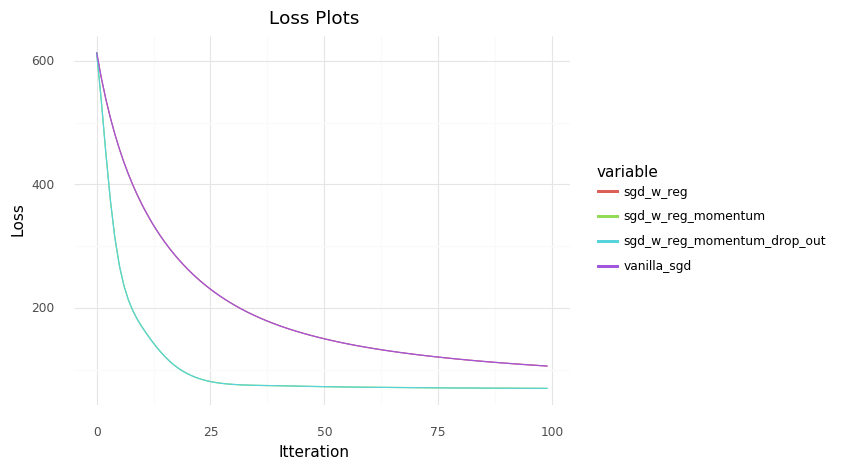

<ggplot: (8729838401698)>

In [47]:
# loss plots
losses = pd.DataFrame({"sgd_w_reg_momentum":sgd_w_reg_momentum['losses'],
                      "sgd_w_reg":sgd_w_reg['losses'],
                      "vanilla_sgd":vanilla_sgd['losses'],
                      "sgd_w_reg_momentum_drop_out":sgd_w_reg_momentum_drop_out['losses']})
df_plot = pd.melt(losses.reset_index(), id_vars="index")


# print out final loss
print(f"final sgd_w_reg_momentum loss: {sgd_w_reg_momentum['loss_i']}")
print(f"final sgd_w_reg loss: {sgd_w_reg['loss_i']}")
print(f"final sgd_w_reg_momentum loss: {sgd_w_reg_momentum['loss_i']}")
print(f"final sgd_w_reg_momentum_drop_out loss: {sgd_w_reg_momentum_drop_out['loss_i']}")

# Plot  losses for each model
(ggplot(df_plot) + geom_line(aes(y='value', x='index', color='variable')) + 
 theme_minimal() + 
 labs(x = "Itteration", y = "Loss", title="Loss Plots"))


### B. 
Next, we repeat the process with more nodes in the hidden layer. 

In [48]:
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              nodes_in_hidden_layer = 5, # Changed in method def. because of bug
              momentum_include = False,
              drop_out_include = False)
              
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              nodes_in_hidden_layer = 5,
              drop_out_include = False)
 
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              nodes_in_hidden_layer = 5,
                              drop_out_include = False)

sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      nodes_in_hidden_layer = 5,
                                      drop_out_include = True) 


            ---- Iteration 0 ----
            Error rate : 0.5665665665665666
            Loss: 2614.817307396562
            

            ---- Iteration 25 ----
            Error rate : 0.19519519519519518
            Loss: 611.3706509095945
            

            ---- Iteration 50 ----
            Error rate : 0.06806806806806807
            Loss: 383.2276735915491
            

            ---- Iteration 75 ----
            Error rate : 0.042042042042042045
            Loss: 251.5054950877491
            

            ---- Iteration 0 ----
            Error rate : 0.5665665665665666
            Loss: 2614.812898743622
            

            ---- Iteration 25 ----
            Error rate : 0.19519519519519518
            Loss: 611.3780321566293
            

            ---- Iteration 50 ----
            Error rate : 0.06806806806806807
            Loss: 383.2431105201206
            

            ---- Iteration 75 ----
            Error rate : 0.042042042042042045
           

### a. Best Performance

The best perfomance was again from **SGD with momentum and dropout, SGD with momentum, and SGD with regularization**.  These all achieved the same final loss.

#### b. Better Performance than in part a?


**No, this model did not achive better performance.** The final loss was close, but a little higher.  It appeared that before regularization was helpfull for model performance.  So adding more layers is increasing the flexibility of the model, but would then require more regularization.


final sgd_w_reg_momentum loss: 79.41837832531564
final sgd_w_reg loss: 182.38034452239893
final sgd_w_reg_momentum loss: 79.41837832531564
final sgd_w_reg_momentum_drop_out loss: 79.41837832531564


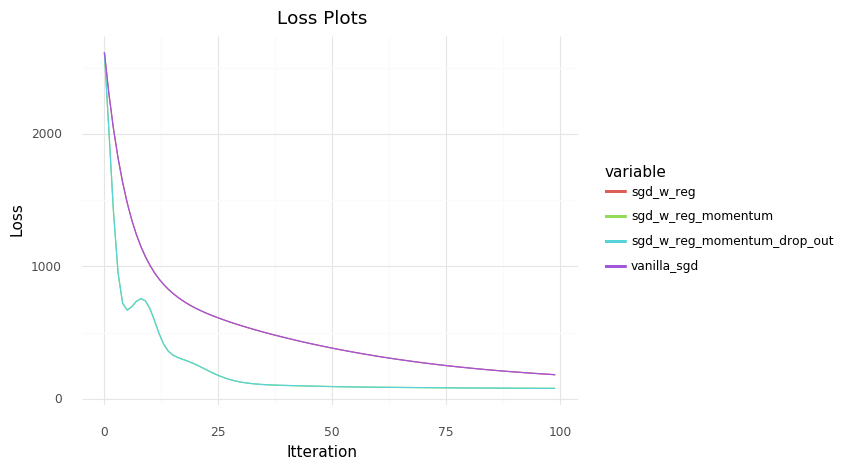

<ggplot: (-9223363307016338253)>

In [49]:
# loss plots
losses = pd.DataFrame({"sgd_w_reg_momentum":sgd_w_reg_momentum['losses'],
                      "sgd_w_reg":sgd_w_reg['losses'],
                      "vanilla_sgd":vanilla_sgd['losses'],
                      "sgd_w_reg_momentum_drop_out":sgd_w_reg_momentum_drop_out['losses']})
df_plot = pd.melt(losses.reset_index(), id_vars="index")

# print out final loss
print(f"final sgd_w_reg_momentum loss: {sgd_w_reg_momentum['loss_i']}")
print(f"final sgd_w_reg loss: {sgd_w_reg['loss_i']}")
print(f"final sgd_w_reg_momentum loss: {sgd_w_reg_momentum['loss_i']}")
print(f"final sgd_w_reg_momentum_drop_out loss: {sgd_w_reg_momentum_drop_out['loss_i']}")

# Plot  losses for each model
(ggplot(df_plot) + geom_line(aes(y='value', x='index', color='variable')) + 
 theme_minimal() + 
 labs(x = "Itteration", y = "Loss", title="Loss Plots"))


#### C. 
Next the following code repeats the same as part a but while timing the function calls.

In [51]:
start_time = time.clock()
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,      
              drop_out_include = False)
vanilla_sgd_time = time.clock() - start_time, "seconds"

start_time = time.clock()
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
sgd_w_reg_time = time.clock() - start_time, "seconds"

start_time = time.clock()
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)
sgd_w_reg_momentum_time = time.clock() - start_time, "seconds"

start_time = time.clock()
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 
sgd_w_reg_momentum_time = time.clock() - start_time, "seconds"

/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.



            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5034085448333
            

            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.39605917572294
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.17197232981292
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
            Loss: 120.61145170075918
            

            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            


/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  



            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.4035439464711
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.18172488031507
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
            Loss: 120.62280456538743
            

            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            


/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app



            ---- Iteration 25 ----
            Error rate : 0.024024024024024024
            Loss: 80.9829547192347
            

            ---- Iteration 50 ----
            Error rate : 0.026026026026026026
            Loss: 72.76404956100707
            

            ---- Iteration 75 ----
            Error rate : 0.026026026026026026
            Loss: 70.850859028104
            


/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            

            ---- Iteration 25 ----
            Error rate : 0.024024024024024024
            Loss: 80.9829547192347
            

            ---- Iteration 50 ----
            Error rate : 0.026026026026026026
            Loss: 72.76404956100707
            

            ---- Iteration 75 ----
            Error rate : 0.026026026026026026
            Loss: 70.850859028104
            


/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


The following prints the training times as a table.  From this we can see that Vanilla SGD took the longest to run (0.77 seconds) probably because it had perhaps more variable calculations that were slightly more intensive.  Then SGD with regularization was the next longest.  Then lastly both the momentum methods took the same time to train.

In [56]:
# print out Training times
pd.DataFrame({"sgd_w_reg_momentum":sgd_w_reg_momentum_time,
               "sgd_w_reg":sgd_w_reg_time,
               "vanilla_sgd":vanilla_sgd_time,
               "sgd_w_reg_momentum_drop_out":sgd_w_reg_momentum_time})    

,sgd_w_reg_momentum,sgd_w_reg,vanilla_sgd,sgd_w_reg_momentum_drop_out
0,0.717009,0.738868,0.771099,0.717009
1,seconds,seconds,seconds,seconds


In [51]:
start_time = time.clock()
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,      
              drop_out_include = False)
vanilla_sgd_time = time.clock() - start_time, "seconds"

start_time = time.clock()
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
sgd_w_reg_time = time.clock() - start_time, "seconds"

start_time = time.clock()
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)
sgd_w_reg_momentum_time = time.clock() - start_time, "seconds"

start_time = time.clock()
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 
sgd_w_reg_momentum_time = time.clock() - start_time, "seconds"

/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.



            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5034085448333
            

            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.39605917572294
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.17197232981292
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
            Loss: 120.61145170075918
            

            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            


/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  



            ---- Iteration 25 ----
            Error rate : 0.04504504504504504
            Loss: 230.4035439464711
            

            ---- Iteration 50 ----
            Error rate : 0.03303303303303303
            Loss: 150.18172488031507
            

            ---- Iteration 75 ----
            Error rate : 0.03003003003003003
            Loss: 120.62280456538743
            

            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            


/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app



            ---- Iteration 25 ----
            Error rate : 0.024024024024024024
            Loss: 80.9829547192347
            

            ---- Iteration 50 ----
            Error rate : 0.026026026026026026
            Loss: 72.76404956100707
            

            ---- Iteration 75 ----
            Error rate : 0.026026026026026026
            Loss: 70.850859028104
            


/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



            ---- Iteration 0 ----
            Error rate : 0.34234234234234234
            Loss: 613.5029983606919
            

            ---- Iteration 25 ----
            Error rate : 0.024024024024024024
            Loss: 80.9829547192347
            

            ---- Iteration 50 ----
            Error rate : 0.026026026026026026
            Loss: 72.76404956100707
            

            ---- Iteration 75 ----
            Error rate : 0.026026026026026026
            Loss: 70.850859028104
            


/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


The following prints the training times as a table.  From this we can see that Vanilla SGD took the longest to run (0.77 seconds) probably because it had perhaps more variable calculations that were slightly more intensive.  Then SGD with regularization was the next longest.  Then lastly both the momentum methods took the same time to train.

In [56]:
# print out Training times
pd.DataFrame({"sgd_w_reg_momentum":sgd_w_reg_momentum_time,
               "sgd_w_reg":sgd_w_reg_time,
               "vanilla_sgd":vanilla_sgd_time,
               "sgd_w_reg_momentum_drop_out":sgd_w_reg_momentum_time})    

,sgd_w_reg_momentum,sgd_w_reg,vanilla_sgd,sgd_w_reg_momentum_drop_out
0,0.717009,0.738868,0.771099,0.717009
1,seconds,seconds,seconds,seconds


## Part 2 Relu vs Sigmoid

Fist we need to redefine the forward and gradient functions to use a sigmoid activation function on the hiddle unites and to compute the derivative of sigmoid for backprop.

In [71]:
def forward(X,parameters, drop_out = 1):
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    
    # Forward pass
    a1 = X.dot(W) + b1
    H = sigmoid(a1) * drop_out
    a2 = H.dot(V) + b2
    Y_hat = softmax(a2)
    return H,Y_hat

#%%%%%%%%%%%%%%%
#   Gradient   #
################

def grad(X,H,Y,Y_hat,parameters):  
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    # Gradients - ReLU
    dV = H.T.dot(Y_hat - Y)
    db2 = (Y_hat - Y).sum(axis=0)
    # dW = X.T.dot(((Y_hat - Y).dot(V.T) * (H > 0))) 
    # db1 = ((Y_hat - Y).dot(V.T) * (H > 0)).sum(axis=0)
    
    # Gradients - sigmoid
    dW = X.T.dot((Y_hat-Y).dot(V.T) * (H * (1 - H)))
    db1 = (Y_hat-Y).dot(V.T) * (H * (1 - H)).sum(axis=0)
    
    
    #return {'dV':dV,'db2':db2,'dW':dW,'db1':db1}
    return dW,db1,dV,db2

### a. Comparing Relu to Sigmoid -- The General Case

The folloing runs the sigmoid model with all of the different regularization methods and plots their losses.

This model performs a lot better when there is regularization than the RuLU did, but performed worse without regularization.

In [66]:
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,  
              drop_out_include = False)
              
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
 
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)

sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 


            ---- Iteration 0 ----
            Error rate : 0.36536536536536535
            Loss: 815.5770638412325
            

            ---- Iteration 25 ----
            Error rate : 0.15315315315315314
            Loss: 567.097113716236
            

            ---- Iteration 50 ----
            Error rate : 0.01901901901901902
            Loss: 469.01670271879595
            

            ---- Iteration 75 ----
            Error rate : 0.005005005005005005
            Loss: 387.8344540999427
            

            ---- Iteration 0 ----
            Error rate : 0.36536536536536535
            Loss: 815.5771341691316
            

            ---- Iteration 25 ----
            Error rate : 0.15315315315315314
            Loss: 567.1073790261585
            

            ---- Iteration 50 ----
            Error rate : 0.01901901901901902
            Loss: 469.0381060873975
            

            ---- Iteration 75 ----
            Error rate : 0.005005005005005005
         

final sgd_w_reg_momentum loss: 18.272865606471093
final sgd_w_reg loss: 321.87625187276035
final sgd_w_reg_momentum loss: 18.272865606471093
final sgd_w_reg_momentum_drop_out loss: 18.272865606471093


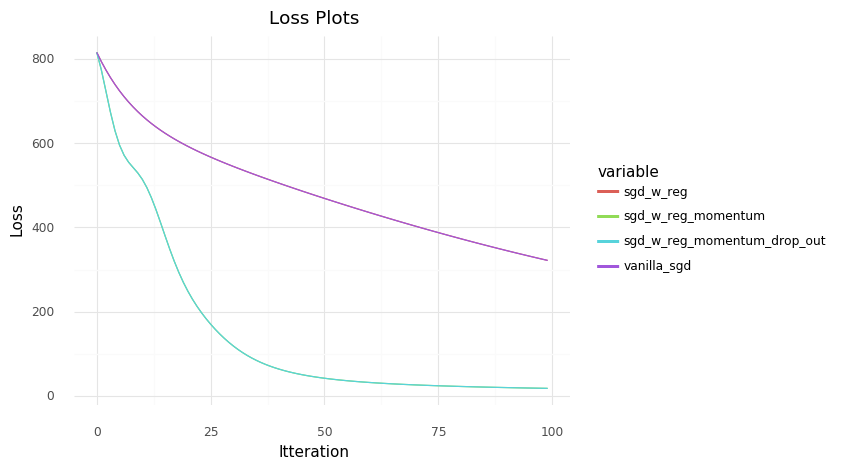

<ggplot: (8729838354587)>

In [63]:
# loss plots
losses = pd.DataFrame({"sgd_w_reg_momentum":sgd_w_reg_momentum['losses'],
                      "sgd_w_reg":sgd_w_reg['losses'],
                      "vanilla_sgd":vanilla_sgd['losses'],
                      "sgd_w_reg_momentum_drop_out":sgd_w_reg_momentum_drop_out['losses']})
df_plot = pd.melt(losses.reset_index(), id_vars="index")


# print out final loss
print(f"final sgd_w_reg_momentum loss: {sgd_w_reg_momentum['loss_i']}")
print(f"final sgd_w_reg loss: {sgd_w_reg['loss_i']}")
print(f"final sgd_w_reg_momentum loss: {sgd_w_reg_momentum['loss_i']}")
print(f"final sgd_w_reg_momentum_drop_out loss: {sgd_w_reg_momentum_drop_out['loss_i']}")

# Plot  losses for each model
(ggplot(df_plot) + geom_line(aes(y='value', x='index', color='variable')) + 
 theme_minimal() + 
 labs(x = "Itteration", y = "Loss", title="Loss Plots"))


### b. Comparing Changes in Hidden Nodes

Next we will see how incresing the number of hidden nodes impacts this network versus ReLu.

Again, it appears that all the regualizing methods performaed better than vanilla SGD.  However this model performed even better with 5 hidden nodes than with 3, which was not the case for the ReLu model.

In [72]:
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              nodes_in_hidden_layer = 5, # Changed in method def. because of bug
             num_classes = 3,
             momentum_include = False,
              drop_out_include = False)
              
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              nodes_in_hidden_layer = 5,
              drop_out_include = False)
 
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              nodes_in_hidden_layer = 5,
                              drop_out_include = False)

sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      nodes_in_hidden_layer = 5,
                                      drop_out_include = True) 


            ---- Iteration 0 ----
            Error rate : 0.6566566566566566
            Loss: 1450.5864416279028
            

            ---- Iteration 25 ----
            Error rate : 0.3113113113113113
            Loss: 744.7528054802333
            

            ---- Iteration 50 ----
            Error rate : 0.004004004004004004
            Loss: 478.7947491808475
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 340.58028230286243
            

            ---- Iteration 0 ----
            Error rate : 0.6566566566566566
            Loss: 1450.5855664869064
            

            ---- Iteration 25 ----
            Error rate : 0.3113113113113113
            Loss: 744.7595116809231
            

            ---- Iteration 50 ----
            Error rate : 0.004004004004004004
            Loss: 478.8169756302764
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 340.61070552448325
     

final sgd_w_reg_momentum loss: 12.185149948759548
final sgd_w_reg loss: 259.6760937527415
final sgd_w_reg_momentum loss: 12.185149948759548
final sgd_w_reg_momentum_drop_out loss: 12.185149948759548


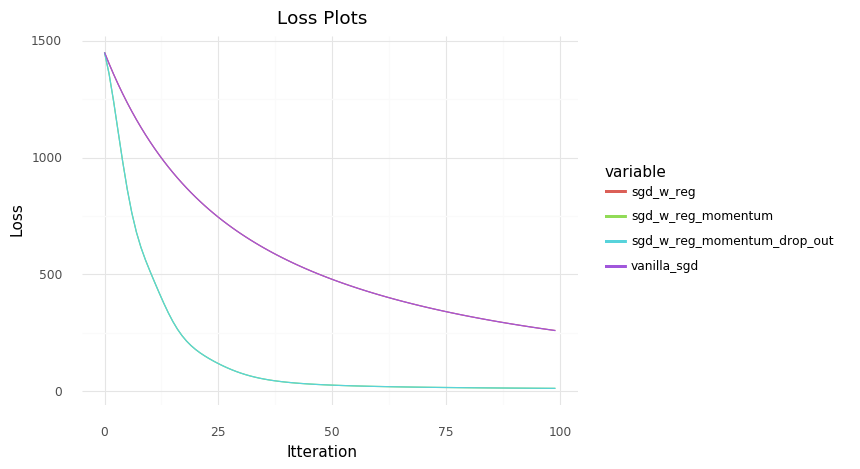

<ggplot: (8729859966917)>

In [73]:
# loss plots
losses = pd.DataFrame({"sgd_w_reg_momentum":sgd_w_reg_momentum['losses'],
                      "sgd_w_reg":sgd_w_reg['losses'],
                      "vanilla_sgd":vanilla_sgd['losses'],
                      "sgd_w_reg_momentum_drop_out":sgd_w_reg_momentum_drop_out['losses']})
df_plot = pd.melt(losses.reset_index(), id_vars="index")

# print out final loss
print(f"final sgd_w_reg_momentum loss: {sgd_w_reg_momentum['loss_i']}")
print(f"final sgd_w_reg loss: {sgd_w_reg['loss_i']}")
print(f"final sgd_w_reg_momentum loss: {sgd_w_reg_momentum['loss_i']}")
print(f"final sgd_w_reg_momentum_drop_out loss: {sgd_w_reg_momentum_drop_out['loss_i']}")

# Plot  losses for each model
(ggplot(df_plot) + geom_line(aes(y='value', x='index', color='variable')) + 
 theme_minimal() + 
 labs(x = "Itteration", y = "Loss", title="Loss Plots"))


### c. Model Time


Lastly, this is the code to test model times for the Sigmoid network.  **This network is also way faster**.  Each model takes only about 0.2 seconds to train, compared to the average 0.7 seconds for the ReLU models.

In [74]:
start_time = time.clock()
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,      
              drop_out_include = False)
vanilla_sgd_time = time.clock() - start_time, "seconds"

start_time = time.clock()
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
sgd_w_reg_time = time.clock() - start_time, "seconds"

start_time = time.clock()
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)
sgd_w_reg_momentum_time = time.clock() - start_time, "seconds"

start_time = time.clock()
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 
sgd_w_reg_momentum_time = time.clock() - start_time, "seconds"

/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/home/jack/anacon


            ---- Iteration 0 ----
            Error rate : 0.36436436436436437
            Loss: 815.3601004579307
            

            ---- Iteration 25 ----
            Error rate : 0.17017017017017017
            Loss: 564.24839046222
            

            ---- Iteration 50 ----
            Error rate : 0.02902902902902903
            Loss: 471.0530296173153
            

            ---- Iteration 75 ----
            Error rate : 0.009009009009009009
            Loss: 394.6392869884486
            

            ---- Iteration 0 ----
            Error rate : 0.36436436436436437
            Loss: 815.3601696175726
            

            ---- Iteration 25 ----
            Error rate : 0.17017017017017017
            Loss: 564.2584226286873
            

            ---- Iteration 50 ----
            Error rate : 0.02902902902902903
            Loss: 471.0737413120504
            

            ---- Iteration 75 ----
            Error rate : 0.009009009009009009
           

/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/jack/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


The following prints the training times as a table.  From this we can see that Vanilla SGD took the longest to run (0.77 seconds) probably because it had perhaps more variable calculations that were slightly more intensive.  Then SGD with regularization was the next longest.  Then lastly both the momentum methods took the same time to train.

In [75]:
# print out Training times
pd.DataFrame({"sgd_w_reg_momentum":sgd_w_reg_momentum_time,
               "sgd_w_reg":sgd_w_reg_time,
               "vanilla_sgd":vanilla_sgd_time,
               "sgd_w_reg_momentum_drop_out":sgd_w_reg_momentum_time})    

,sgd_w_reg_momentum,sgd_w_reg,vanilla_sgd,sgd_w_reg_momentum_drop_out
0,0.069746,0.061969,0.084799,0.069746
1,seconds,seconds,seconds,seconds
